In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm
import scipy.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.3 MB/s 
     |████████████████████████████████| 100 kB 10.4 MB/s 


DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term



## Safety PDE with data

In [3]:
import scipy.io
mat1 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/ground_truth.mat')
mat2 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC100.mat')
mat3 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC.mat')
mat4 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10000.mat')
mat5 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10e5.mat')
mat6 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10.mat')
safety_pde = mat1['F2']
safety_pde.shape # (109, 10000)
MC100 = mat2['U2']
MC = mat3['U2']
MC10000 = mat4['U2']
MC10e5 = mat5['U2']
MC10 = mat6['U2']
MC.shape # (109, 10000)
safety_pde[50:109, ::100].shape # (59, 100)

safety_pde = safety_pde[50:109, ::100]
MC10 = MC10[50:109, ::100]
MC100 = MC100[50:109, ::100]
MC = MC[50:109, ::100]
MC10000 = MC10000[50:109, ::100]
MC10e5 = MC10e5[50:109, ::100]

bnd = np.ones([1,100])
bnd.shape # (1, 100)
safety_pde = np.append(safety_pde, bnd, axis=0)
MC10 = np.append(MC10, bnd, axis=0)
MC100 = np.append(MC100, bnd, axis=0)
MC = np.append(MC, bnd, axis=0)
MC10000 = np.append(MC10000, bnd, axis=0)
MC10e5 = np.append(MC10e5, bnd, axis=0)

MC.shape # (60, 100)

(60, 100)

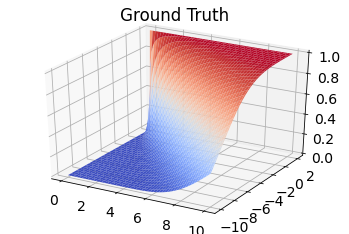

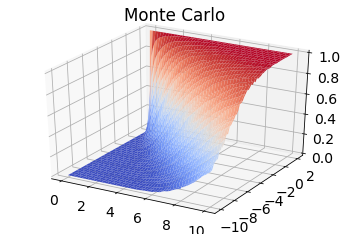

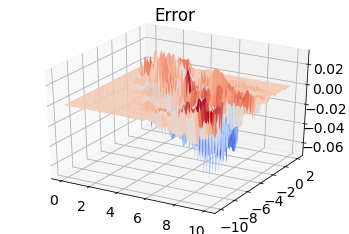

In [ ]:
x = np.linspace(0,10,100)
y = np.linspace(-10,2,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, safety_pde, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Ground Truth')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, MC, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Monte Carlo')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

ha.plot_surface(X, Y, MC - safety_pde, cmap=cm.coolwarm) # X: time, Y: state

plt.title('Error')

plt.show()

### Resampling for generalization

In [4]:
MC_sub = MC10000[::2,::5][0:20,:] # sub-sampling as training data
MC_sub.shape # (20, 20)

observe_x_data = np.mgrid[-9.8:-2:0.4, 0.1:10:0.5].reshape(2,-1).T
observe_x_data.shape # (400, 2)

observe_func_data = MC_sub.reshape(-1,1)

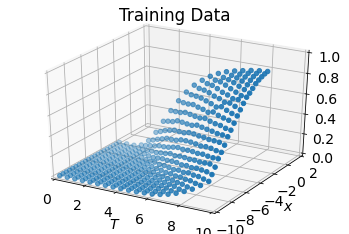

In [6]:
x = np.linspace(0.1,9.6,20)
y = np.arange(-9.8, -2, 0.4)

X, Y = np.meshgrid(x, y)

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(X, Y, MC_sub) # X: time, Y: state
ha.set_xlim(0, 10)
ha.set_ylim(-10, 2)
ha.set_zlim(0, 1)
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("Training Data")
plt.show()

In [7]:
bc = np.mgrid[2:2.1:1, 0.1:10:0.5].reshape(2,-1).T
ic = np.mgrid[-9.8:1.7:0.4, 0:0.1:1].reshape(2,-1).T
bc.shape # (20, 2)
ic.shape # (30, 2)
bc_func = np.ones([20,1])
ic_func = np.zeros([29,1])

observe_x_temp = np.append(observe_x_data, bc, axis=0)
observe_x_temp
observe_x = np.append(observe_x_temp, ic, axis=0)
observe_x

observe_func_temp = np.append(observe_func_data, bc_func, axis=0)
observe_func_temp
observe_func = np.append(observe_func_temp, ic_func, axis=0)
# observe_func

### Fixed PDE

In [8]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - 0.5 * dy_xx
        - 1 * dy_x
    )

In [10]:
observe_y = dde.icbc.PointSetBC(observe_x, observe_func, component=0)

geom = dde.geometry.Interval(-10, 2)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    num_domain=200,
    # num_boundary=20,
    # num_initial=10,
    anchors=observe_x,
)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  total_n_samples))


In [11]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=[]
)
variable = dde.callbacks.VariableValue([], period=1000)
model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.070594 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.544127 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.08e-02, 9.24e-01]    [2.08e-02, 9.24e-01]    []  
0 []
1000      [2.43e-04, 9.92e-04]    [2.43e-04, 9.92e-04]    []  
1000 []
2000      [1.28e-04, 5.62e-04]    [1.28e-04, 5.62e-04]    []  
2000 []
3000      [8.47e-05, 3.82e-04]    [8.47e-05, 3.82e-04]    []  
3000 []
4000      [4.89e-05, 2.54e-04]    [4.89e-05, 2.54e-04]    []  
4000 []
5000      [2.32e-05, 1.51e-04]    [2.32e-05, 1.51e-04]    []  
5000 []
6000      [1.33e-05, 5.94e-05]    [1.33e-05, 5.94e-05]    []  
6000 []
7000      [7.85e-06, 4.05e-05]    [7.85e-06, 4.05e-05]    []  
7000 []
8000      [3.79e-06, 2.32e-05]    [3.79e-06, 2.32e-05]    []  
8000 []
9000      [2.07e-06, 1.25e-05]    [2.07e-06, 1.25e-05]    []  
9000 []
10000     [1.55e-06, 1.14e-05]    [1.55e-06, 1.14e-05]    []  
10000 []
11000     [1.29e-06, 1.11e-05]    [1.29e-06, 1.11e-05]    []  
11000 []
12000  

(<deepxde.model.LossHistory at 0x7f3cab9ef8d0>,
 <deepxde.model.TrainState at 0x7f3cab9ef810>)

In [15]:
test_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
test_x.shape # (6000, 2)
test_y = safety_pde.reshape(-1,1)
test_y.shape # (6000, 1)

yhat = model.predict(test_x)

yhat.shape # (6000, 1)

safety_predict = yhat.reshape(60,-1)
safety_predict

array([[-1.6587973e-04, -1.6649067e-04, -1.7894804e-04, ...,
         2.8438783e-01,  2.9691011e-01,  3.0954367e-01],
       [-1.2578070e-04, -1.2549758e-04, -1.3674796e-04, ...,
         3.0770612e-01,  3.2054055e-01,  3.3345228e-01],
       [-8.7559223e-05, -8.6292624e-05, -9.6887350e-05, ...,
         3.3179098e-01,  3.4487665e-01,  3.5800546e-01],
       ...,
       [ 1.9847767e-01,  3.4244937e-01,  4.8207653e-01, ...,
         1.0000565e+00,  1.0001081e+00,  1.0001614e+00],
       [ 5.3574193e-01,  6.4443743e-01,  7.4192101e-01, ...,
         1.0002351e+00,  1.0002882e+00,  1.0003430e+00],
       [ 1.0000050e+00,  1.0013242e+00,  9.9074501e-01, ...,
         1.0004045e+00,  1.0004603e+00,  1.0005176e+00]], dtype=float32)

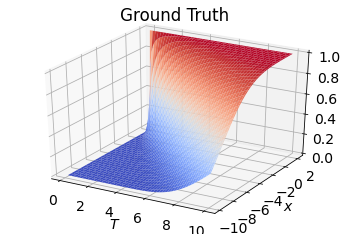

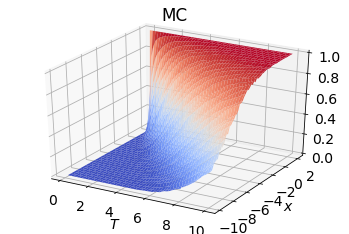

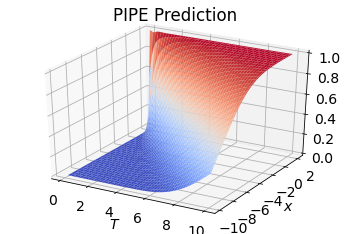

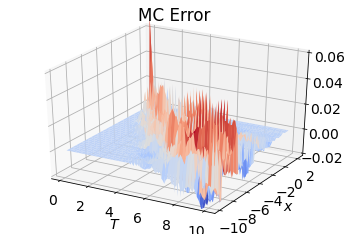

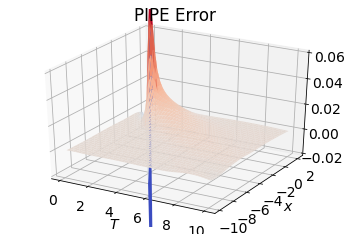

In [19]:
x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("Ground Truth")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, MC, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("MC")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_predict, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Prediction")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.set_zlim(-0.02, 0.06)
ha.plot_surface(X, Y, safety_pde - MC, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("MC Error")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.set_zlim(-0.02, 0.06)
ha.plot_surface(X, Y, safety_pde-safety_predict, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error")
plt.show()

In [21]:
mat6 = scipy.io.loadmat('/content/drive/MyDrive/MC data/fitting/poly55.mat')
mat7 = scipy.io.loadmat('/content/drive/MyDrive/MC data/fitting/lowess.mat')
mat8 = scipy.io.loadmat('/content/drive/MyDrive/MC data/fitting/cubic_spline.mat')
mat9 = scipy.io.loadmat('/content/drive/MyDrive/MC data/fitting/biharmonic.mat')
mat0 = scipy.io.loadmat('/content/drive/MyDrive/MC data/fitting/tps.mat')
poly55 = mat6['U_fit']
lowess = mat7['U_fit']
cubic = mat8['U_fit']
biharmonic = mat9['U_fit']
tps = mat0['U_fit']
cubic_num = np.nan_to_num(cubic)
poly55.shape # (60, 100)

(60, 100)

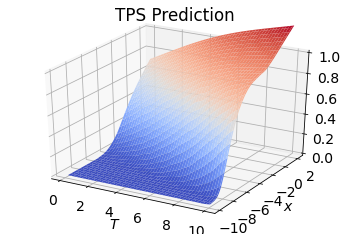

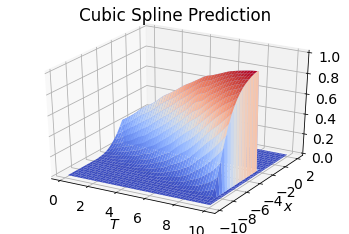

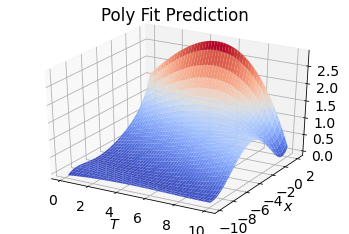

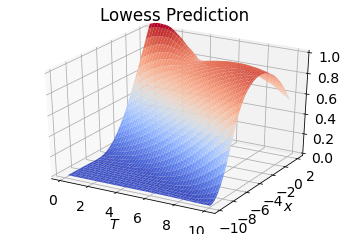

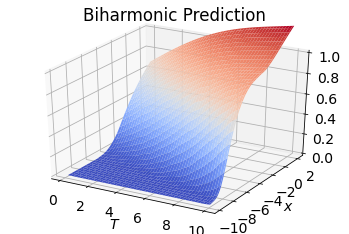

In [25]:
x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, tps, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("TPS Prediction")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_zlim(0, 1)

x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, cubic_num, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Cubic Spline Prediction")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_zlim(0, 1)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, poly55, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Poly Fit Prediction")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, lowess, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Lowess Prediction")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_zlim(0, 1)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, biharmonic, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("Biharmonic Prediction")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_zlim(0, 1)

plt.show()

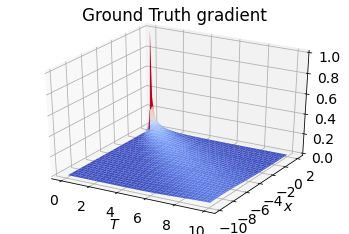

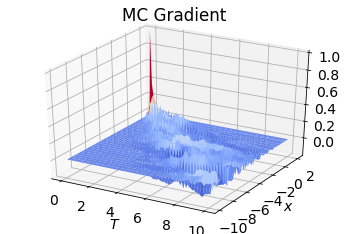

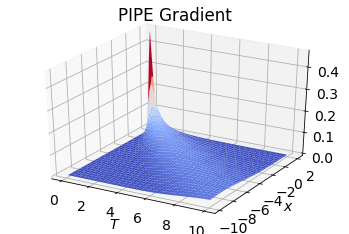

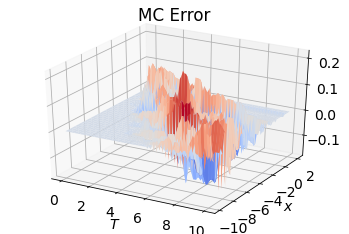

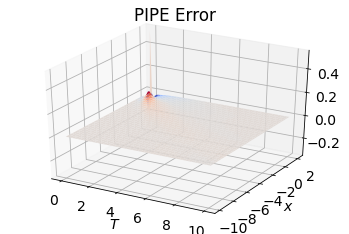

In [18]:
GT_grad = np.diff(safety_pde, axis=0) # gradient of state dF/dx
MC_grad = np.diff(MC100, axis=0)
PINN_grad = np.diff(safety_predict5, axis=0)

x = np.linspace(0,10,100)
y = np.linspace(-9.8,2,59)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("Ground Truth gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, MC_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("MC Gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, PINN_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Gradient")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad - MC_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("MC Gradient Error")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, GT_grad - PINN_grad, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Gradient Error")
plt.show()

In [26]:
error_NN = safety_pde-safety_predict
print(np.average(abs(error_NN))) # 0.003382234932241756
error_fit = safety_pde-tps
np.average(abs(error_fit)) # 0.09245016818251624
gradient_error_NN = GT_grad - PINN_grad
np.average(abs(gradient_error_NN)) # 0.0006199242829057887
# gradient_error_MC = GT_grad - MC_grad
# np.average(abs(gradient_error_MC)) # 0.027838523319294633

0.0026759877812558824


0.0006447444131904533

### Ablation Experiments

In [ ]:
pred_error = np.zeros([6,10])
gradient_error = np.zeros([6,10])
for i in range(1,5):
    for j in range(10):
        layer_size = [2] + [32] * i + [1]
        activation = "tanh"
        initializer = "Glorot uniform"
        net = dde.nn.FNN(layer_size, activation, initializer)

        model = dde.Model(data, net)

        model.compile(
            "adam", lr=0.001, external_trainable_variables=[]
        )
        variable = dde.callbacks.VariableValue([], period=1000)
        model.train(epochs=60000, callbacks=[variable])

        test_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
        test_y = safety_pde.reshape(-1,1)

        yhat = model.predict(test_x)
        safety_predict5 = yhat.reshape(60,-1)

        GT_grad = np.diff(safety_pde, axis=0) # gradient of state dF/dx
        MC_grad = np.diff(MC100, axis=0)
        PINN_grad = np.diff(safety_predict5, axis=0)

        error_NN = safety_pde-safety_predict5
        gradient_error_NN = GT_grad - PINN_grad

        pred_error[i-1, j] = np.average(abs(error_NN))
        gradient_error[i-1, j] = np.average(abs(gradient_error_NN))

In [ ]:
for j in range(10):
    layer_size = [2] + [16] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)

    model.compile(
        "adam", lr=0.001, external_trainable_variables=[]
    )
    variable = dde.callbacks.VariableValue([], period=1000)
    model.train(epochs=60000, callbacks=[variable])

    test_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
    test_y = safety_pde.reshape(-1,1)

    yhat = model.predict(test_x)
    safety_predict5 = yhat.reshape(60,-1)

    GT_grad = np.diff(safety_pde, axis=0) # gradient of state dF/dx
    MC_grad = np.diff(MC100, axis=0)
    PINN_grad = np.diff(safety_predict5, axis=0)

    error_NN = safety_pde-safety_predict5
    gradient_error_NN = GT_grad - PINN_grad

    pred_error[4, j] = np.average(abs(error_NN))
    gradient_error[4, j] = np.average(abs(gradient_error_NN))

for j in range(10):
    layer_size = [2] + [64] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)

    model.compile(
        "adam", lr=0.001, external_trainable_variables=[K1,K2]
    )
    variable = dde.callbacks.VariableValue([K1,K2], period=1000)
    model.train(epochs=60000, callbacks=[variable])

    test_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
    test_y = safety_pde.reshape(-1,1)

    yhat = model.predict(test_x)
    safety_predict5 = yhat.reshape(60,-1)

    GT_grad = np.diff(safety_pde, axis=0) # gradient of state dF/dx
    MC_grad = np.diff(MC100, axis=0)
    PINN_grad = np.diff(safety_predict5, axis=0)

    error_NN = safety_pde-safety_predict5
    gradient_error_NN = GT_grad - PINN_grad

    pred_error[5, j] = np.average(abs(error_NN))
    gradient_error[5, j] = np.average(abs(gradient_error_NN))

In [ ]:
print(np.average(pred_error, axis=1))
print(np.average(gradient_error, axis=1))
print(np.std(pred_error, axis=1))
print(np.std(gradient_error, axis=1))